In [1]:
import matplotlib
matplotlib.use('nbagg')
print(matplotlib.get_backend())


nbAgg


In [15]:
import os
import matplotlib.pyplot as plt
from os import listdir
import random
import numpy as np
import cv2 as cv
import timeit

In [9]:
dataset_location = 'C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/images'
#dataset_location = 'C:/Users/sushl/Downloads/Archives/data_odometry_gray/dataset/sequences/01/image_0'
L = os.listdir(dataset_location)
L.sort()


In [10]:
ground_truth = np.loadtxt('C:/Users/sushl/Downloads/Visual-Odometry-master/Visual-Odometry-master/KITTI_sample/poses.txt',delimiter = ' ')
#ground_truth = np.loadtxt('C:/Users/sushl/Desktop/New Text Document.txt',delimiter = ' ')
ground_truth.shape
gx = ground_truth[:,3]
gz = ground_truth[:,11]

In [11]:

k =np.array([[7.188560000000e+02, 0.000000000000e+00, 6.071928000000e+02], 
             [0.000000000000e+00, 7.188560000000e+02, 1.852157000000e+02], 
             [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00]])

In [12]:
sift = cv.SIFT_create()
bf = cv.BFMatcher()

In [23]:

scale = 1
trans= {}
rot = {}

for a in range(len(L)-2):
    #start2 = timeit.timeit()
    sift = cv.SIFT_create()
    bf = cv.BFMatcher()

    img1 = cv.imread(dataset_location +'/'+ L[a],cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(dataset_location +'/'+ L[a+1],cv.IMREAD_GRAYSCALE)
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    matches = bf.knnMatch(des1,des2,k=2)
    
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    src_p = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_p=np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    
    pts1 = np.float32(src_p)
    pts2 = np.float32(dst_p)

    R = []
    t = []
    
    #F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
    F,mask = cv.findFundamentalMat(pts1, pts2,cv.FM_RANSAC ,0.4,0.9,mask=None)
    E = k.T@F@k
        
    retval, R, t, mask = cv.recoverPose(E, pts1, pts2, k)
    
    if a == 0:
        trans[a] = -1*R@t
        rot[a] = R
    else:
        rot[a] = rot[a-1]@R
        trans[a] = trans[a-1] - rot[a]@t
    


<IPython.core.display.Javascript object>


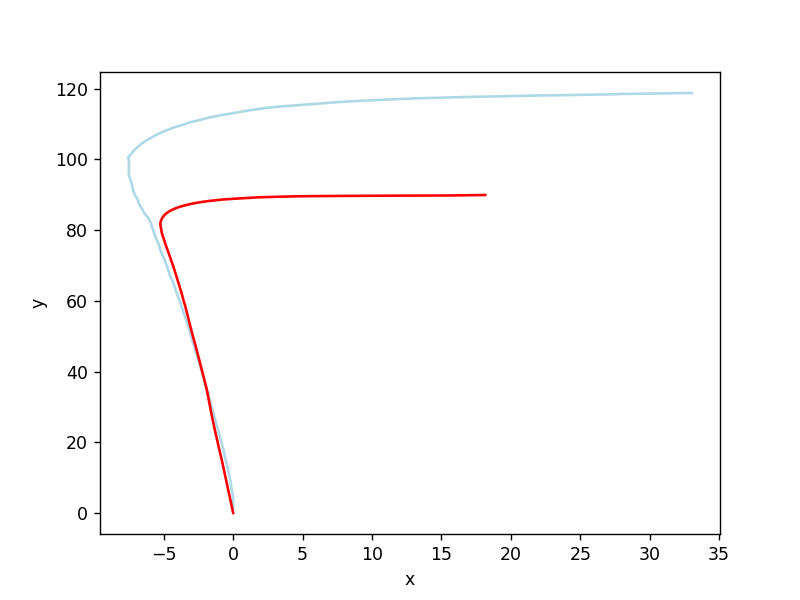

In [14]:
x0 = []
y0 = []

for i in trans:
    y0.append(trans[i][2])
    x0.append(-1*trans[i][0])

fig = plt.figure()
ax = plt.axes()
ax.plot(x0, y0,color = "lightblue")
ax.plot(gx, gz,color = 'red')
#ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()